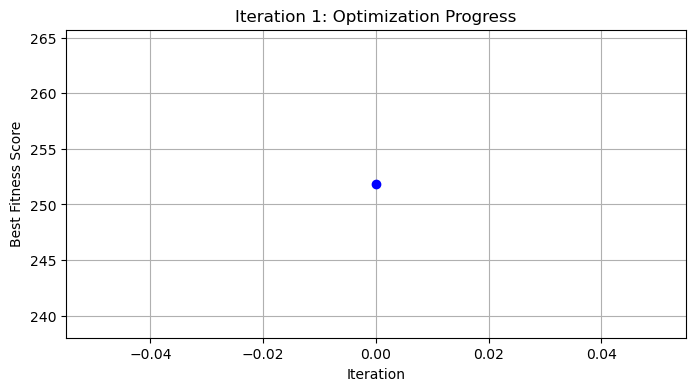

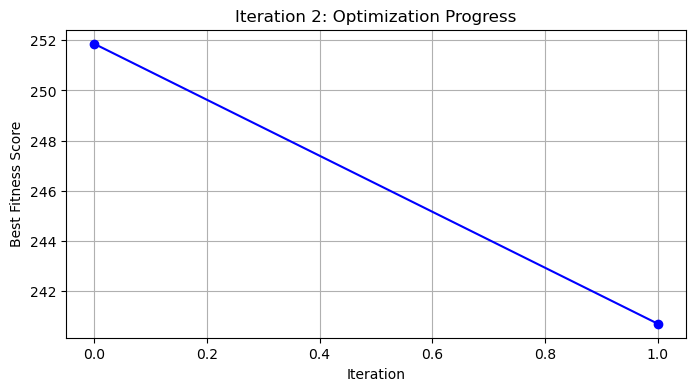

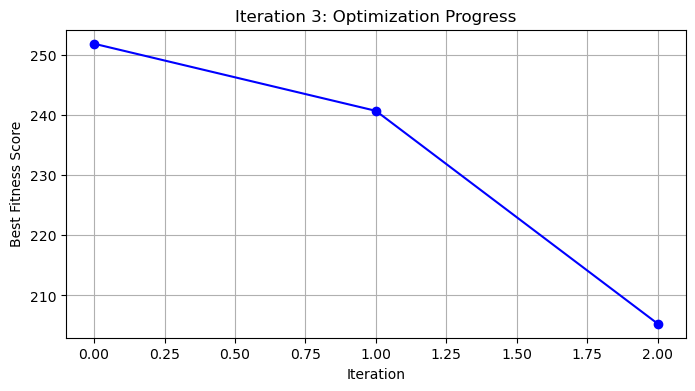

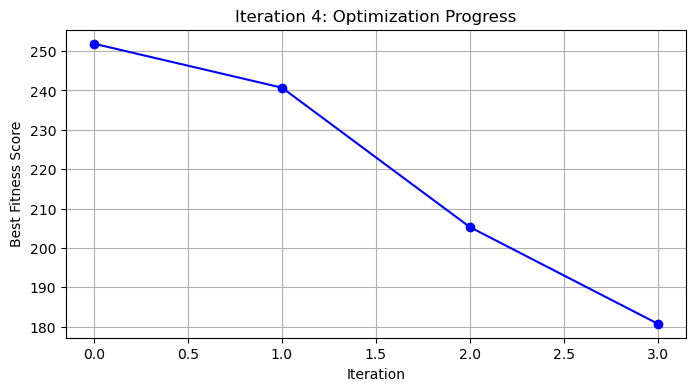

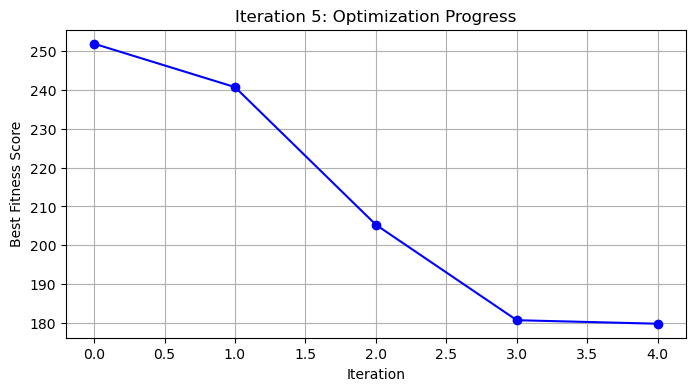

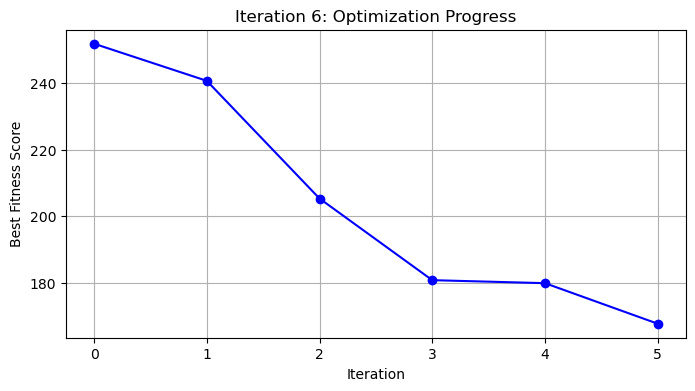

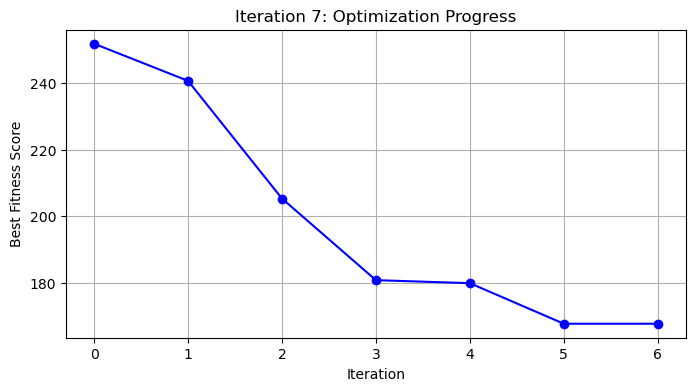

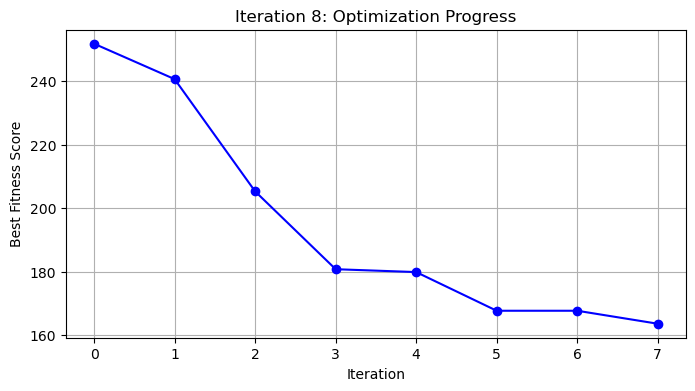

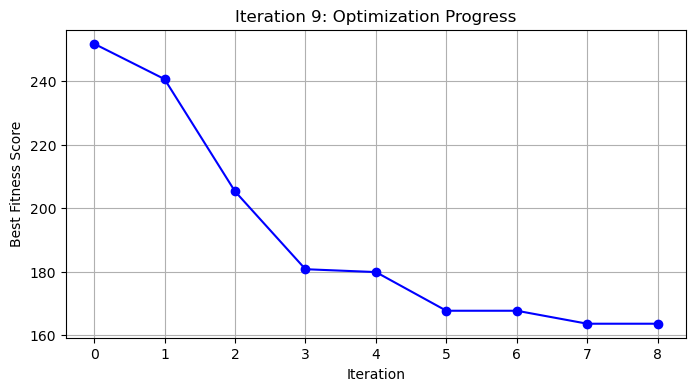

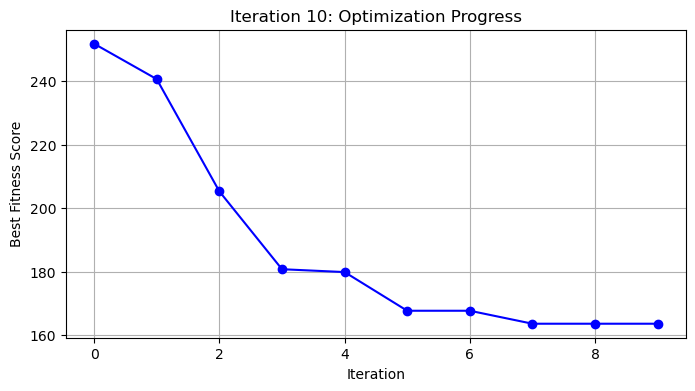

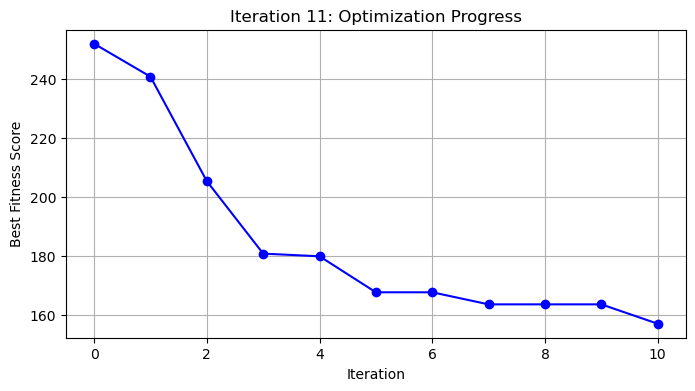

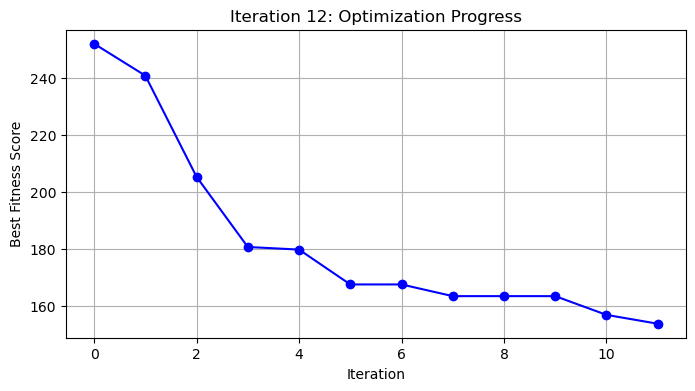

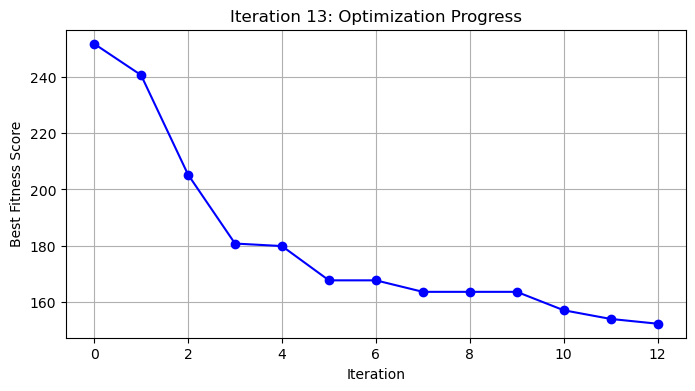

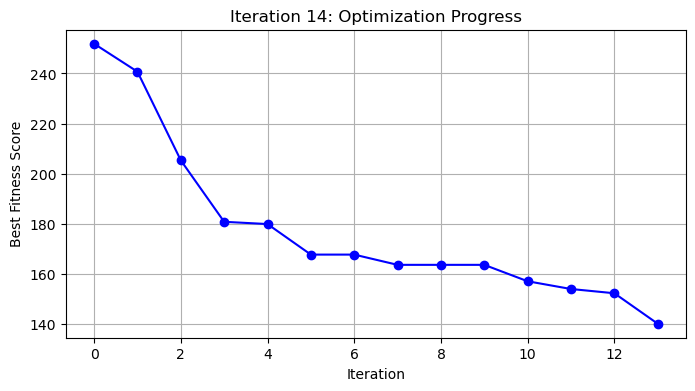

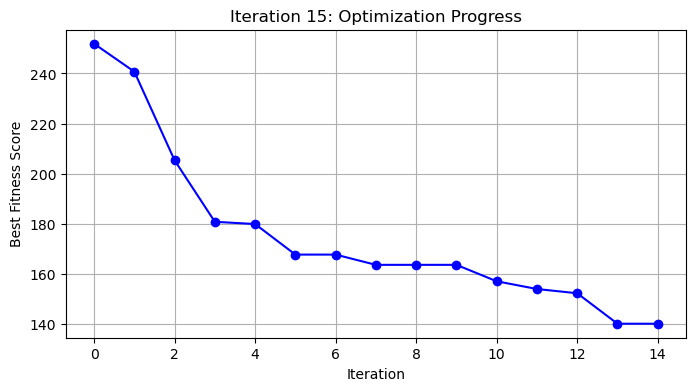

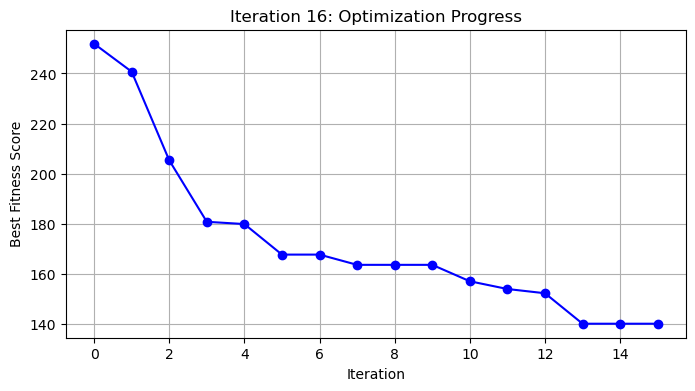

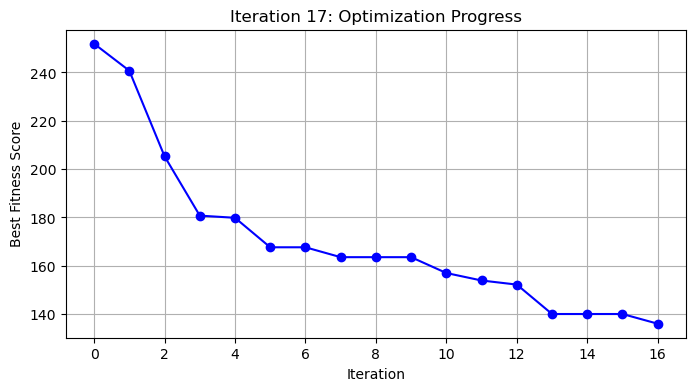

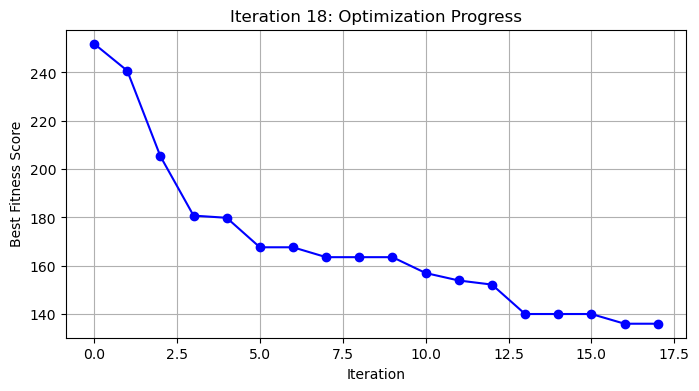

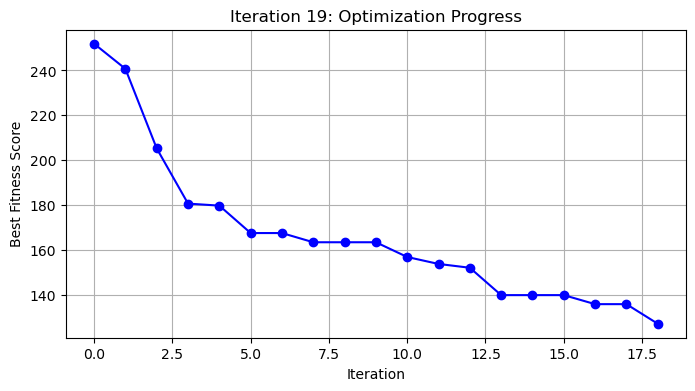

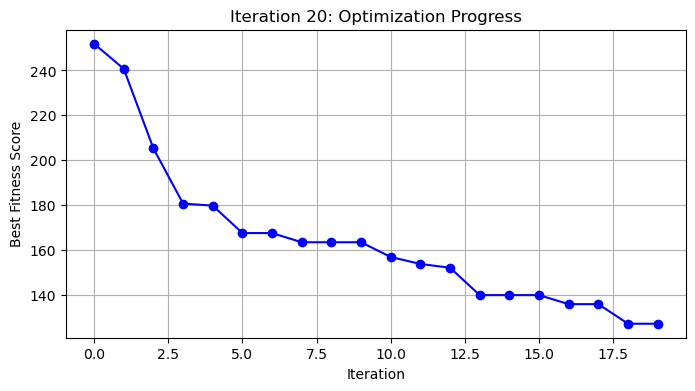

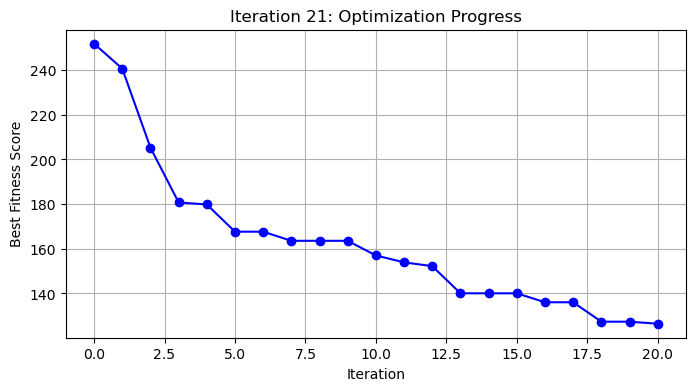

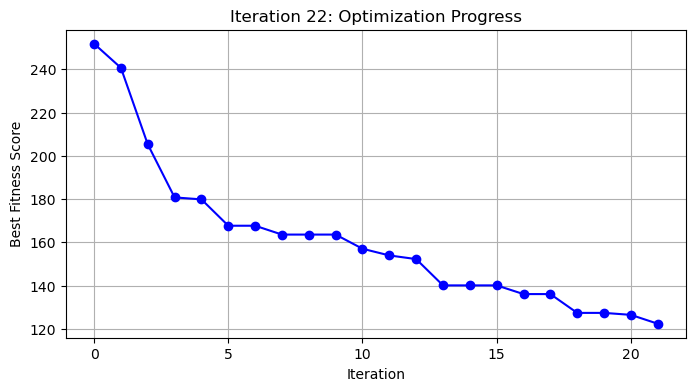

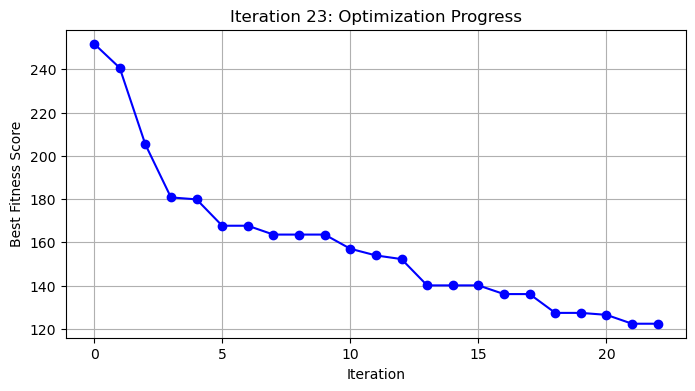

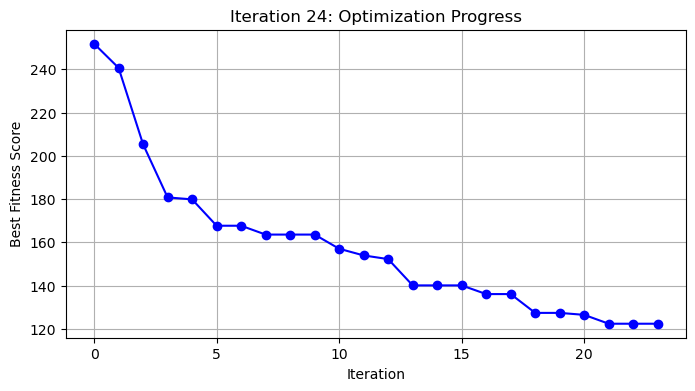

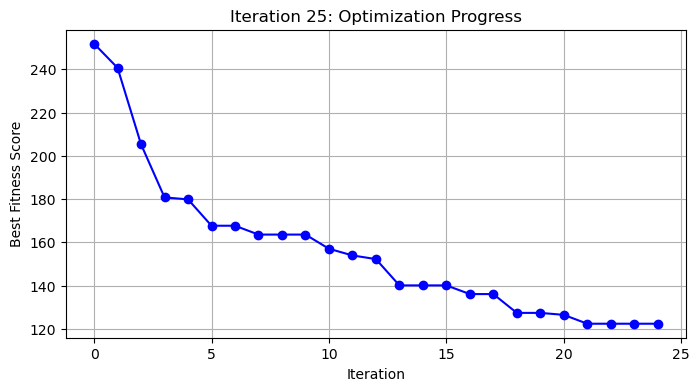

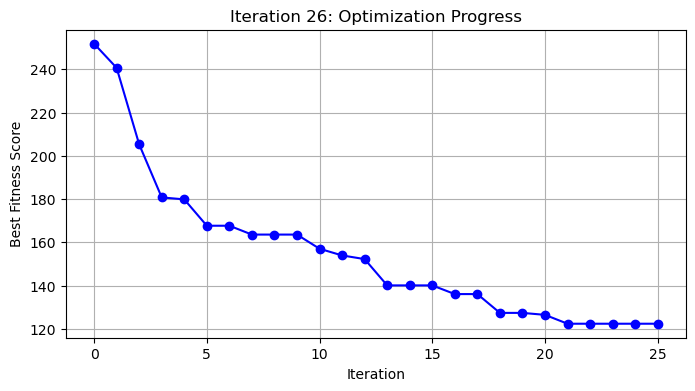

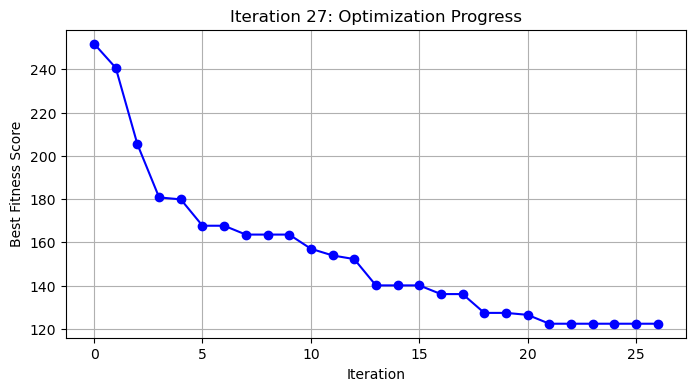

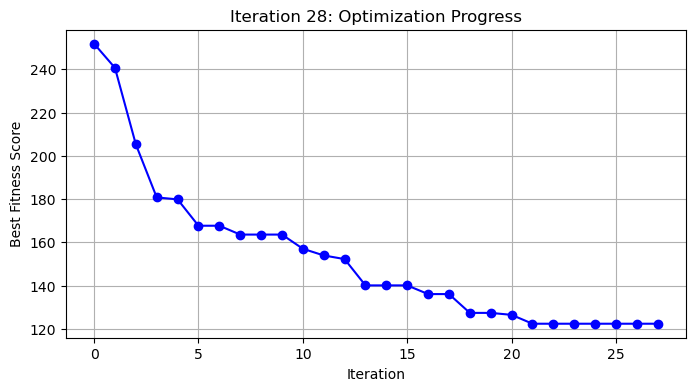

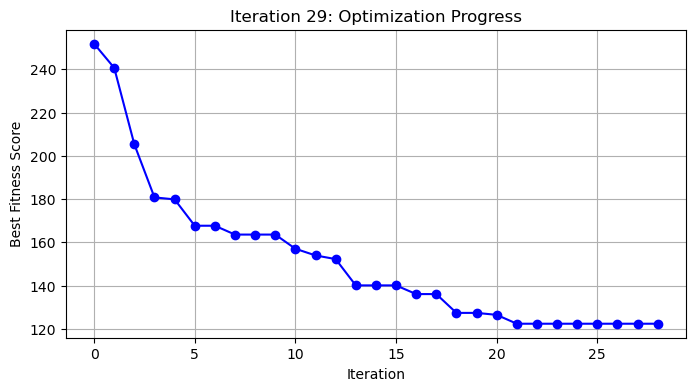

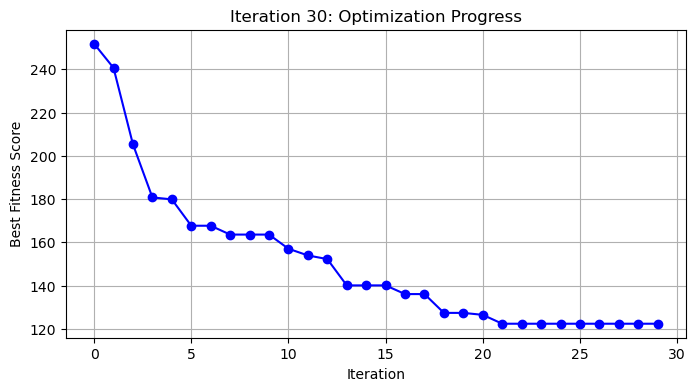

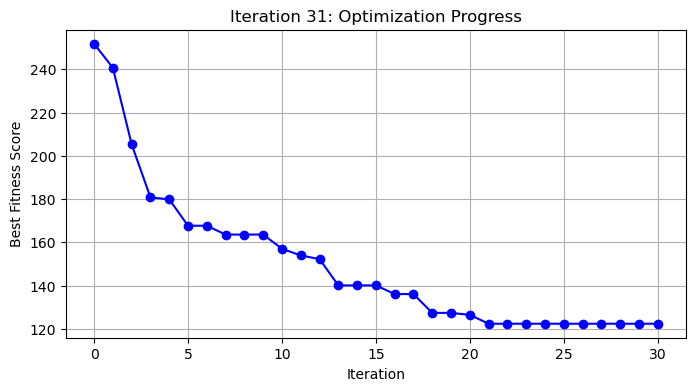

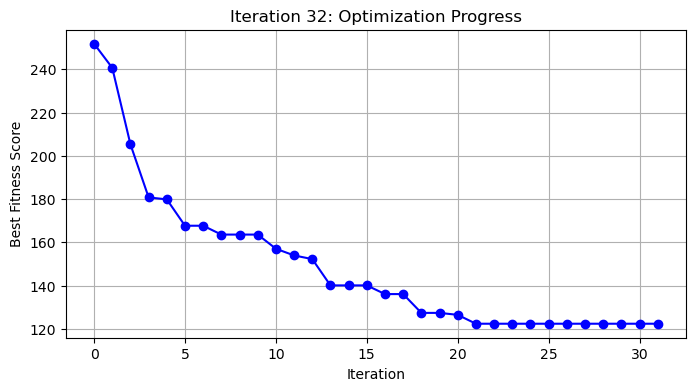

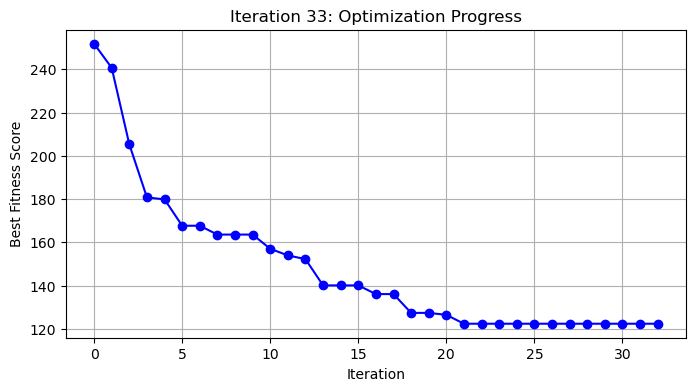

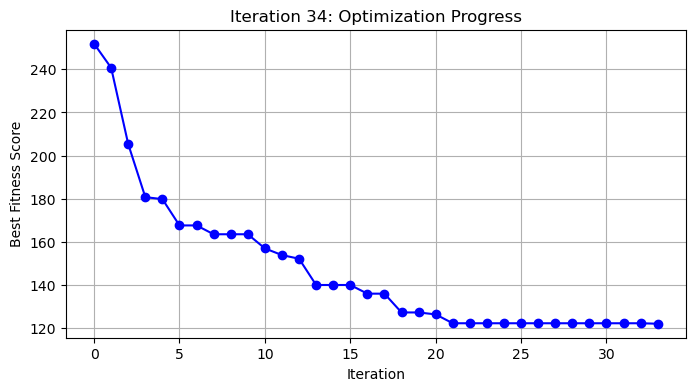

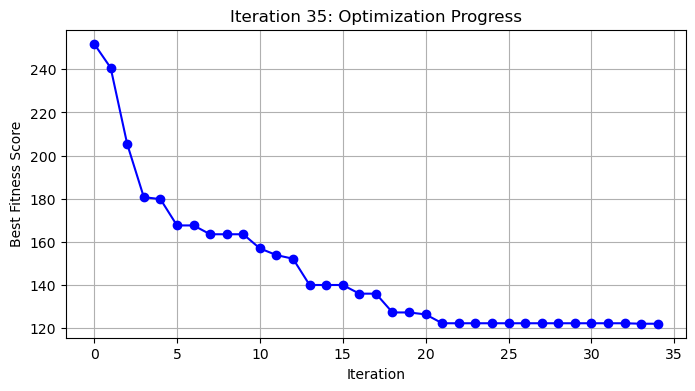

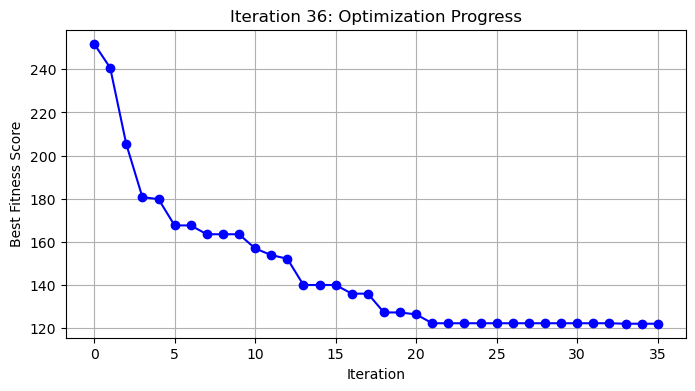

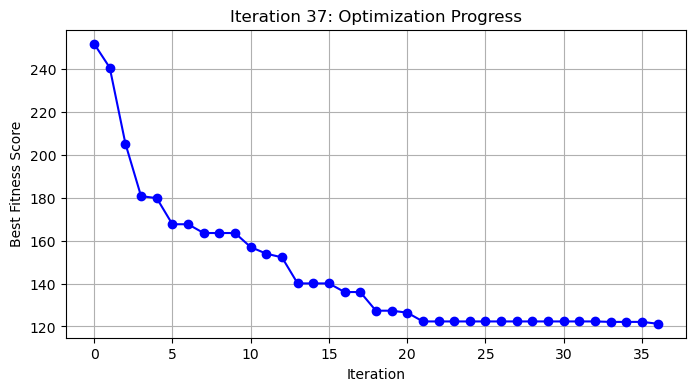

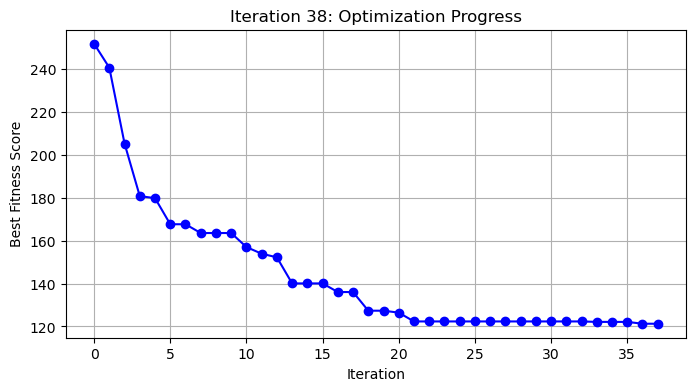

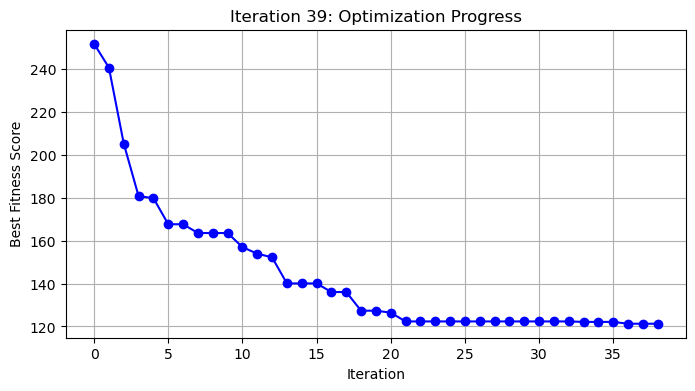

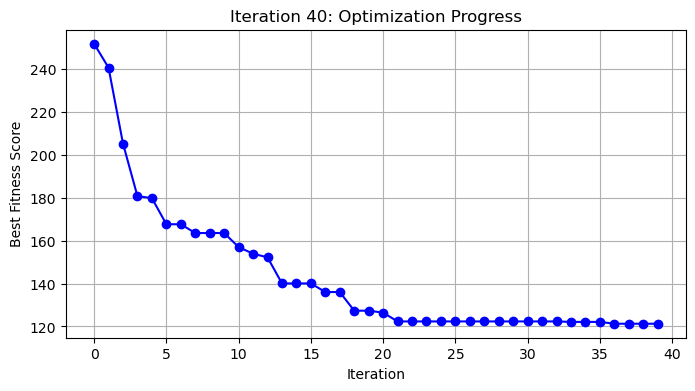

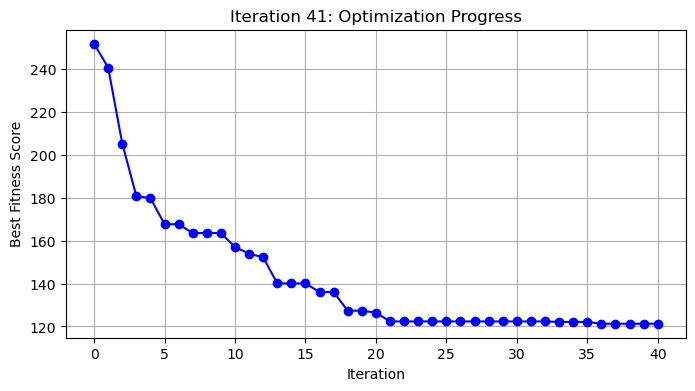

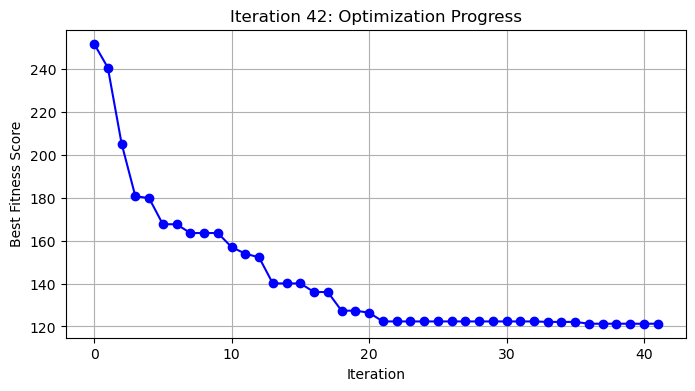

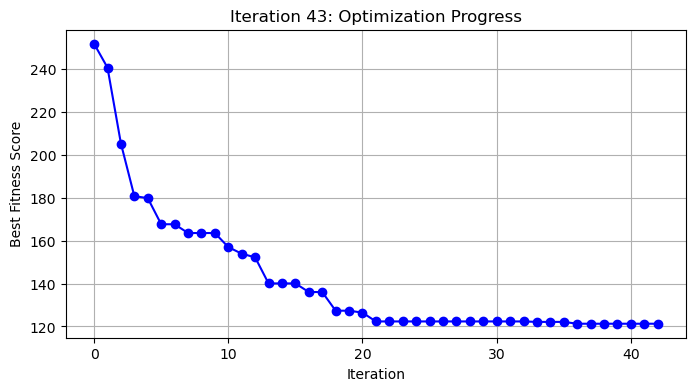

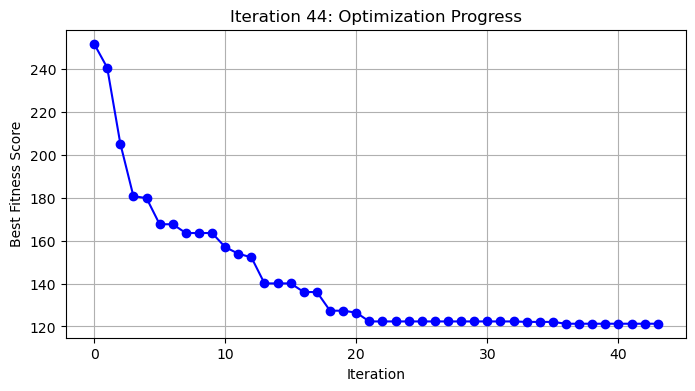

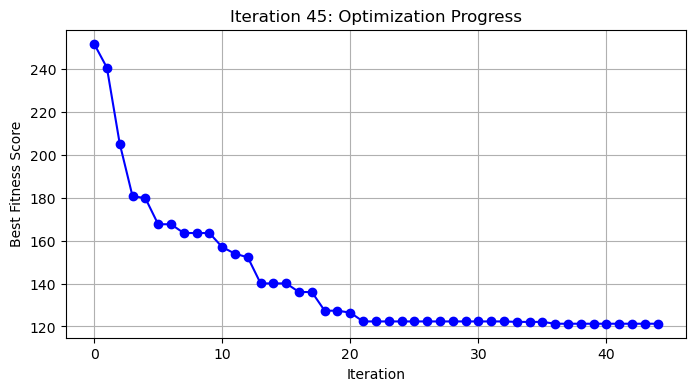

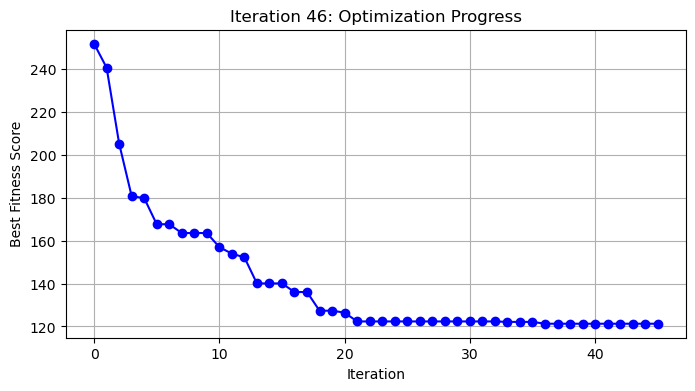

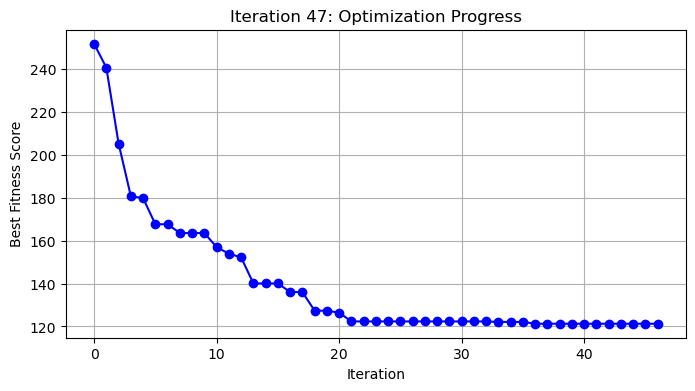

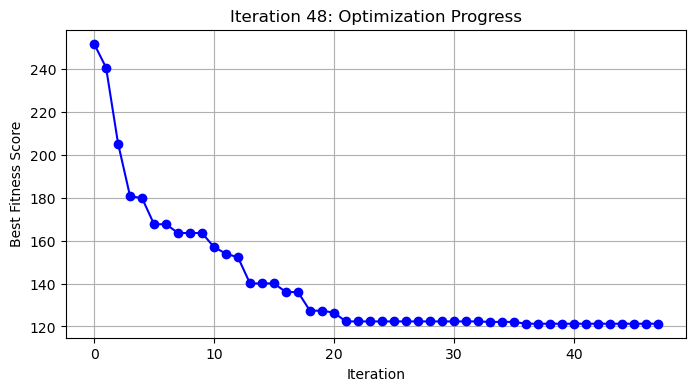

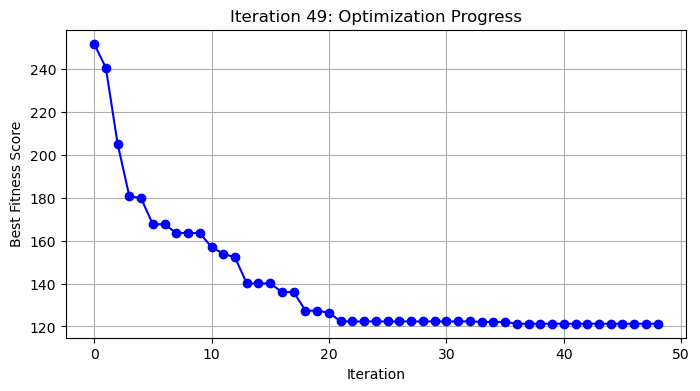

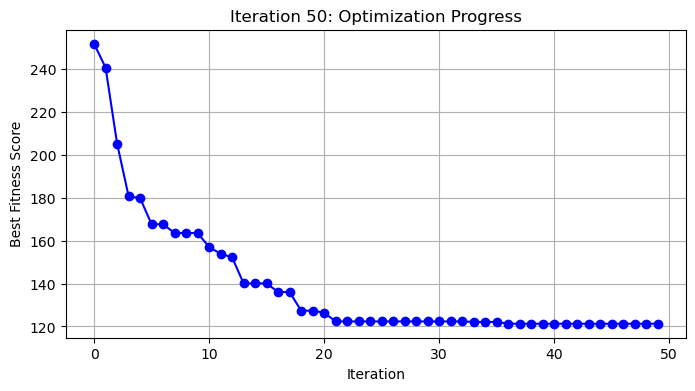


Optimized Traffic Signal Timings:
Indiranagar: 50.78 seconds
100 Feet Road: 10.06 seconds
CMH Road: 10.06 seconds
Whitefield: 10.06 seconds
Marathahalli Bridge: 10.06 seconds
Koramangala: 10.06 seconds
Sony World Junction: 10.06 seconds
Sarjapur Road: 10.06 seconds
M.G. Road: 10.06 seconds
Trinity Circle: 10.06 seconds
Anil Kumble Circle: 10.06 seconds
Jayanagar: 10.06 seconds
Jayanagar 4th Block: 10.06 seconds
South End Circle: 10.06 seconds
Hebbal: 10.06 seconds
Hebbal Flyover: 58.83 seconds
Ballari Road: 10.06 seconds
Yeshwanthpur: 10.06 seconds
Yeshwanthpur Circle: 10.06 seconds
Tumkur Road: 10.06 seconds
ITPL Main Road: 55.59 seconds
Electronic City: 10.06 seconds
Silk Board Junction: 56.92 seconds
Hosur Road: 58.82 seconds


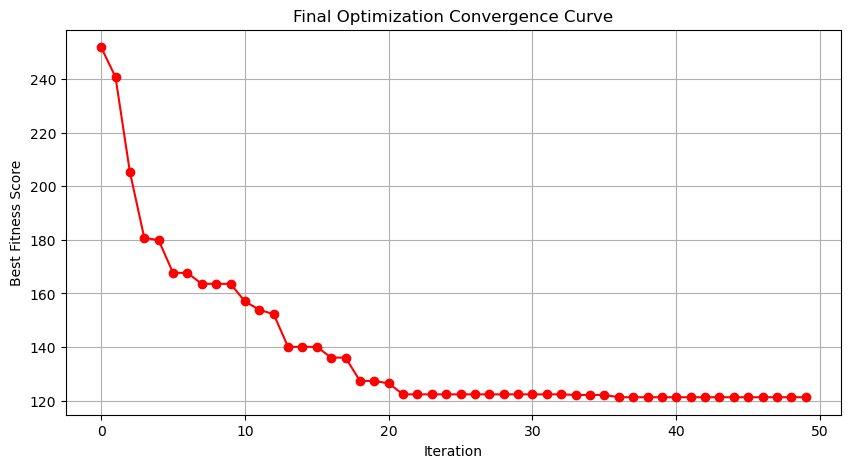

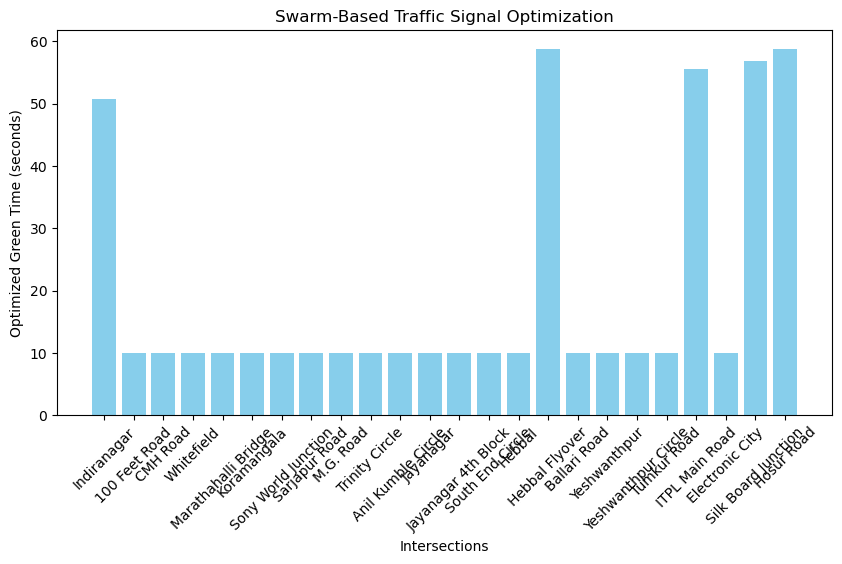

In [ ]:
#--------cell 1--------
# Import libraries
import numpy as np
import pandas as pd
import networkx as nx #manage road network graph
import matplotlib.pyplot as plt # graph visualization

# Load Traffic Dataset
file_path = r"Banglore_traffic_Dataset.csv"
data = pd.read_csv(file_path)

# Extract intersections and traffic data
intersections = data['Road/Intersection Name'].unique()
num_intersections = len(intersections)
traffic_data = {data['Road/Intersection Name'][i]: data['Traffic Volume'][i] for i in range(len(data))}

# Graph Representation (Road Network)
road_network = nx.Graph()
for i in range(len(data)):
    road_network.add_edge(data['Area Name'][i], data['Road/Intersection Name'][i])

#--------cell 2--------
# Particle Class (Traffic Signal Configuration)
class Particle:
    def __init__(self, num_intersections):
        self.position = np.random.uniform(10, 60, num_intersections)  # Green time (10s-60s)
        self.velocity = np.zeros(num_intersections)
        self.p_best = self.position.copy()
        self.p_best_score = float('inf')

def fitness_function(position, traffic_data):
    intersection_names = list(traffic_data.keys())
    return sum([position[i] / (traffic_data.get(intersection_names[i], 1) + 1) for i in range(len(position))])

# Swarm Initialization
class Swarm:
    def __init__(self, swarm_size, num_intersections):
        self.particles = [Particle(num_intersections) for _ in range(swarm_size)]
        self.global_best_position = np.random.uniform(10, 60, num_intersections)
        self.global_best_score = float('inf')

#--------cell 3--------
# PSO Algorithm
swarm_size = 10
max_iterations = 50

# Dynamic inertia weight for better convergence
w_max, w_min = 0.9, 0.4
c1, c2 = 1.2, 1.2  # Reduced to prevent extreme jumps

num_intersections = len(road_network)
swarm = Swarm(swarm_size, num_intersections)

# Store best scores for plotting convergence
best_scores = []

# Main PSO Loop (50 Iterations)
for iteration in range(max_iterations):
    w = w_max - (w_max - w_min) * (iteration / max_iterations)  # Adaptive inertia weight

    for particle in swarm.particles:
        # Extract intersection names from road_network
        intersection_names = list(road_network.nodes)
        traffic_values = {name: traffic_data.get(name, 0) for name in intersection_names}

        # Compute fitness
        score = fitness_function(particle.position, traffic_values)

        # Update personal & global bests
        if score < particle.p_best_score:
            particle.p_best = particle.position.copy()
            particle.p_best_score = score
        if score < swarm.global_best_score:
            swarm.global_best_position = particle.position.copy()
            swarm.global_best_score = score

    best_scores.append(swarm.global_best_score)  # Store for plotting
    #Har iteration ke baad global best score store hota hai taaki optimization progress ko track kiya ja sake.

    
    # Plot optimization curve at each step(Har iteration ke baad optimization curve plot hota hai.)
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(best_scores)), best_scores, marker='o', linestyle='-', color='blue')
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness Score")
    plt.title(f"Iteration {iteration + 1}: Optimization Progress")
    plt.grid()
    plt.show()

    #--------cell 4--------
    # Update Velocity & Position
    for particle in swarm.particles:
        r1, r2 = np.random.rand(), np.random.rand()
        particle.velocity = (w * particle.velocity) + (c1 * r1 * (particle.p_best - particle.position)) + (c2 * r2 * (swarm.global_best_position - particle.position))
        particle.position += particle.velocity

        # Ensure values stay within limits with some randomness
        particle.position = np.where(particle.position < 10, 10 + np.random.uniform(0, 5), particle.position)
        particle.position = np.where(particle.position > 60, 60 - np.random.uniform(0, 5), particle.position)

#--------cell 5--------
# Ensure intersections variable has the correct length
#(Ensures ki jitne intersections optimize hue hain, utne hi display ho.)
if len(intersections) != num_intersections:
    intersections = np.array(intersection_names[:num_intersections])

# Final Optimized Traffic Signal Timings
optimized_times = swarm.global_best_position
optimized_traffic_signals = {intersections[i]: optimized_times[i] for i in range(num_intersections)}

# Display Results
print("\nOptimized Traffic Signal Timings:")
for key, value in optimized_traffic_signals.items():
    print(f"{key}: {value:.2f} seconds")

# Final Convergence Curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(best_scores)), best_scores, marker='o', linestyle='-', color='red')
plt.xlabel("Iteration")           #(Kitne steps tak algorithm chala)
plt.ylabel("Best Fitness Score")  #(Kitna optimized solution mila)
plt.title("Final Optimization Convergence Curve")
plt.grid()
plt.show()

# Plot the optimized traffic signal distribution
plt.figure(figsize=(10, 5))
plt.bar(optimized_traffic_signals.keys(), optimized_traffic_signals.values(), color='skyblue')
plt.xlabel("Intersections")
plt.ylabel("Optimized Green Time (seconds)")
plt.title("Swarm-Based Traffic Signal Optimization")
plt.xticks(rotation=45)
plt.show()